# Brand analysis notebook

In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import json
import seaborn as sns
import bisect
from IPython.display import IFrame
%matplotlib inline

In [2]:
import findspark
findspark.init()

import pyspark
conf = pyspark.SparkConf()\
    .setMaster('local[*]')\
    .set('spark.executor.memory', '1g')\
    .set('spark.driver.memory', '1g')\
    .set('spark.executor.instances', '4')
    
sc = pyspark.SparkContext(conf=conf)

### Test and example

##### @todo: why do I need to run it twice?

In [4]:
# New dataset format. salesRankCat and salesRankPos are always included together
sc.textFile('data/reduced.json')\
    .map(lambda x: json.loads(x))\
    .filter(lambda x: 'price' in x and 'related' in x and 'salesRankCat' in x)\
    .take(1)

[{'asin': '9868238854',
  'average_rating': 5.0,
  'category': ['Musical Instruments',
   'Band & Orchestra',
   'Wind & Woodwinds',
   'Recorders'],
  'description': 'Woodnote Tenor Recorder  was made of High performance ABS Plastic Resin and are highly recommended by many buyers and collectors.',
  'helpful_fraction': 1.0,
  'imUrl': 'http://ecx.images-amazon.com/images/I/51h8cIN5FaL._SY300_.jpg',
  'num_reviews': 2,
  'price': 61.41,
  'related': {'also_bought': ['078661790X',
    'B001LQW2KI',
    '0882848143',
    'B001EA71R0',
    '0769219020',
    'B001LQU5W0',
    'B008DYGKEU'],
   'buy_after_viewing': ['B0002MS7O2',
    'B0002D00QE',
    'B000RW20Q8',
    '0882848143']},
  'salesRankCat': 'Musical Instruments',
  'salesRankPos': 60253,
  'title': 'Woodnote Wood Grain Tenor Recorder-Baroque fingering/3 pieces construction'}]

### Load dataset, select category, filter entries

In [67]:
# Collect the products in the "Headphones" category
#cat = ['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Headphones']
cat = ['Electronics', 'Camera & Photo', 'Digital Cameras']
#.filter(lambda x: 'salesRankCat' in x and 'price' in x and 'brand' in x and 'related' in x and 'average_rating' in x)\
#cat = ['Electronics']
records = sc.textFile('data/reduced.json')\
    .map(lambda x: json.loads(x))\
    .filter(lambda x: 'price' in x and 'brand' in x and 'related' in x and 'average_rating' in x)\
    .filter(lambda x: len(x['category']) >= len(cat) and x['category'][:len(cat)] == cat)\
    .collect()

## NB: Create graph with thw following code!

In [216]:
from graph import ProductGraph
g = ProductGraph(records, add_edge_on='buy_after_viewing', remove_edge_on='bought_together')
fan_in = g.get_fan_in()
fan_out = g.get_fan_out()
for i, record in enumerate(g.records):
    record['fan_in'] = fan_in[i]
    record['fan_out'] = fan_out[i]
g = g.drop_singletons()
cliques = g.extract_max_cliques()
len(cliques)

913

In [217]:
count = 0
dim_cliques = 2
for c in cliques:
    if len(c) < dim_cliques:
        continue
    count += 1
    for i in c:
        print('*',g.records[i]['title'], ' - $', g.records[i]['price'])
    print('------')
    
print("\nThere are", len(g.records), "products.")
print("Total number of cliques:", count)

* Southern Telecom Emerson Action Camera Black Digital Cameras  - $ 36.87
* Emerson EVC355BLHD Action Video Camera with 1.2-Inch LCD (Blue)  - $ 40.39
------
* Canon Rebel T5i Digital SLR Camera and 18-55mm EF-S IS STM Lens Kit  - $ 749.0
* Canon EOS Rebel T5i 18.0 MP CMOS Digital Camera with EF-S 18-55mm f/3.5-5.6 IS STM Zoom Lens + EF 75-300mm f/4-5.6 III Telephoto Zoom Lens + Telephoto &amp; Wide Angle Lenses + 12pc Bundle 32GB Deluxe Accessory Kit  - $ 849.0
------
* Nikon COOLPIX S02 13.2 MP Digital Camera with 3x Zoom NIKKOR Glass Lens and Full 1080p HD Video (Pink)  - $ 84.95
* Nikon COOLPIX S01 10.1 MP Digital Camera with 3x Zoom NIKKOR Glass Lens (Pink)  - $ 95.88
------
* Olympus Stylus VG-180 16 Megapixel Compact Camera - Red  - $ 59.95
* Olympus Stylus VG-180 16-Megapixel 5X 26mm Wide Optical Zoom 2.7 Inch LCD - Black  - $ 49.99
* Kodak Easyshare C195 Digital Camera (Red)  - $ 47.44
------
* Olympus Stylus VG-180 16 Megapixel Compact Camera - Red  - $ 59.95
* Kodak Easyshar

# Brand analysis

##### Brand listing

List all brands

In [223]:
brands_total = []

for r in records:
    if 'brand' in r:
        brands_total.append(r['brand'])
        
brands_total_set = sorted(set(brands_total))
print("There are " + str(len(records)) + " records in category.")
print("There are " + str(len(brands_total_set)) + " brands overall.")
#print(brands_total_set)

There are 1311 records in category.
There are 114 brands overall.


List brands in cliques

In [224]:
brands_in_cliques = []

dimension = 2
for c in cliques:
    if len(c) != dimension:
        continue
    for i in c:
        if 'brand' in g.records[i]:
            brands_in_cliques.append(g.records[i]['brand'])


brands_clique_set= sorted(set(brands_in_cliques))
print(str(len(brands_in_cliques)) + " products in cliques are associated to a brand.")
brands_clique_set = sorted(set(brands_in_cliques))
print("There are " + str(len(brands_clique_set)) + " brands in cliques.")
#print(brands_set)

150 products in cliques are associated to a brand.
There are 20 brands in cliques.


##### Brand data augmentation and filtering

##### Dataframe creation

In [236]:
r_df = pd.DataFrame(g.records)

data = []
# works only with dim = 2
dim_cliques = 2

# auxiliary statistics
clique_count = 0
valid_clique_count = 0
# clique id
clique_id = 0
for c in cliques:
    # check dimension
    if len(c) != dim_cliques:
        continue
    # check all different brands
    clique_count += 1
    brand_check = r_df['brand'].loc[c]
    if len(list(set(brand_check))) < dim_cliques:
        continue
    #print(brand_check)
    valid_clique_count += 1
    df_tmp = pd.DataFrame(r_df['fan_in'].loc[c].rank(method='average'))
    df_tmp.columns = ['key']
    df_tmp['title'] = r_df['title'].loc[c]
    df_tmp['brand'] = r_df['brand'].loc[c]
    df_tmp['id'] = clique_id
    clique_id += 1
    data.append(df_tmp)
res = pd.concat(data)
# remove bias
res = res[res.key != 1.5]
# print percentage of remaining cliques
print("Valid cliques:", valid_clique_count/clique_count, "%")
res.head(100)

Valid cliques: 0.14666666666666667 %


,key,title,brand,id
13,1.0,Canon Rebel T5i Digital SLR Camera and 18-55mm...,Canon,1
138,2.0,Canon EOS Rebel T5i 18.0 MP CMOS Digital Camer...,Focus Camera,1
17,1.0,Olympus Stylus VG-180 16 Megapixel Compact Cam...,Olympus,2
659,2.0,Kodak Easyshare C195 Digital Camera (Red),Kodak,2
62,1.0,Olympus Stylus VG-180 16-Megapixel 5X 26mm Wid...,Olympus,3
659,2.0,Kodak Easyshare C195 Digital Camera (Red),Kodak,3
126,2.0,Canon PowerShot G16 12.1 MP CMOS Digital Camer...,Canon,5
532,1.0,Canon PowerShot G16 12.1 MP CMOS Digital Camer...,Focus Camera,5
305,2.0,Nikon COOLPIX P520 18.1 MP CMOS Digital Camera...,Nikon,6
754,1.0,Nikon COOLPIX P520 18.1 MP CMOS Digital Camera...,Focus Camera,6


##### Brand histogram

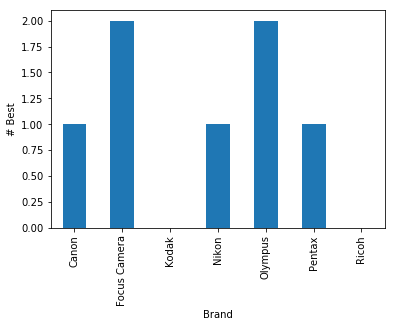

In [242]:
filt_res = res.copy()
filt_res['key'] = res['key'].map(lambda x: 1 if x == 1 else 0)
res_group = filt_res.groupby('brand').agg({'key': 'sum'})
brand_hist = res_group.plot.bar()
brand_hist.legend().set_visible(False)
brand_hist.set_xlabel('Brand')
brand_hist.set_ylabel('# Best')
plt.show()

##### Co-occurence matrix

In [276]:
# build co-occurence matrix with a set
bought_occ = pd.DataFrame(brands_clique_set, columns = ['brand'])
bought_occ = bought_occ.set_index('brand')
for b in brands_clique_set:
    bought_occ[b] = 0
bought_occ.index.rename('most bought over ->', inplace = True)

occ_res = res.copy()
occ_res['key'] = occ_res['key'].map(lambda x: 1 if x == 1 else 0)
res_group = occ_res.groupby('id')

for c_id, c in res_group:
    winner_brand = c[c.key == 1].brand
    loser_brands = c[c.key == 0].brand
    for lb in loser_brands:
        bought_occ.loc[winner_brand, lb] += 1

#brand_data
print("Table dimension: ", bought_occ.shape)
bought_occ = bought_occ.loc[(bought_occ.sum(axis=1) != 0), (bought_occ.sum(axis=0) != 0)]
bought_occ

Table dimension:  (20, 20)


,Canon,Focus Camera,Kodak,Nikon,Ricoh
most bought over ->,,,,,
Canon,0,1,0,0,0
Focus Camera,1,0,0,1,0
Nikon,1,0,0,0,0
Olympus,0,0,2,0,0
Pentax,0,0,0,0,1


# OLD CODE: Create graph and cliques

In [43]:
# Convert string IDs to numeric IDs
name_id_mapping = {}
for i, record in enumerate(records):
    name_id_mapping[record['asin']] = i
    
adj_list = []
adj_set = []
for record in records:
    # Buy after viewing: add edge
    if 'related' in record and 'buy_after_viewing' in record['related']:
        av = record['related']['buy_after_viewing']
    else:
        av = []
    av = list(filter(lambda x: x in name_id_mapping, av))
    adj_list.append(sorted(set([name_id_mapping[x] for x in av])))
    
    # Bought together: remove edge (if added earlier)
    if 'related' in record and 'bought_together' in record['related']:
        bt = record['related']['bought_together']
    else:
        bt = []
    bt = list(filter(lambda x: x in name_id_mapping, bt))
    bt = [name_id_mapping[x] for x in bt]
    for o in bt:
        if o in adj_list[-1]:
            adj_list[-1].remove(o)
    adj_set.append(frozenset(adj_list[-1]))

# Transposed adjacency list (represents the incoming edges in every node)
adj_list_incoming = []
for adj in adj_list:
    adj_list_incoming.append([])
    
for i, adj in enumerate(adj_list):
    for node in adj:
        adj_list_incoming[node].append(i)

In [44]:
cliques = []
def extract_all_cliques(nodes, prev_list):
    count = 0
    m = 0 if len(prev_list) == 0 else bisect.bisect_right(nodes, prev_list[-1])
    for a in nodes[m:]:
        connected = True
        for test in prev_list:
            if test not in adj_set[a] or a not in adj_set[test]:
                connected = False
                break
        
        if connected:
            prev_list.append(a)
            if extract_all_cliques(adj_list[a], prev_list) == 0:
                cliques.append(prev_list.copy())
                count += 1
            prev_list.pop()
    return count

In [45]:
cliques = []
print(extract_all_cliques(range(len(adj_list)), []), 'cliques found')

1244 cliques found


In [9]:
for c in cliques:
    if len(c) < 2:
        continue
    for i in c:
        print('*',records[i]['title'], ' - $', records[i]['price'])
    print('------')

* Southern Telecom Emerson Action Camera Black Digital Cameras  - $ 36.87
* Emerson EVC355BLHD Action Video Camera with 1.2-Inch LCD (Blue)  - $ 40.39
------
* Canon Rebel T5i Digital SLR Camera and 18-55mm EF-S IS STM Lens Kit  - $ 749.0
* Canon EOS Rebel T5i 18.0 MP CMOS Digital Camera with EF-S 18-55mm f/3.5-5.6 IS STM Zoom Lens + EF 75-300mm f/4-5.6 III Telephoto Zoom Lens + Telephoto &amp; Wide Angle Lenses + 12pc Bundle 32GB Deluxe Accessory Kit  - $ 849.0
------
* Nikon COOLPIX S02 13.2 MP Digital Camera with 3x Zoom NIKKOR Glass Lens and Full 1080p HD Video (Pink)  - $ 84.95
* Nikon COOLPIX S01 10.1 MP Digital Camera with 3x Zoom NIKKOR Glass Lens (Pink)  - $ 95.88
------
* Olympus Stylus VG-180 16 Megapixel Compact Camera - Red  - $ 59.95
* Olympus Stylus VG-180 16-Megapixel 5X 26mm Wide Optical Zoom 2.7 Inch LCD - Black  - $ 49.99
* Kodak Easyshare C195 Digital Camera (Red)  - $ 47.44
------
* Olympus Stylus VG-180 16 Megapixel Compact Camera - Red  - $ 59.95
* Kodak Easyshar

In [72]:
fan_in = list(map(lambda x: len(x), adj_list_incoming))
fan_out = list(map(lambda x: len(x), adj_list))
df = pd.DataFrame()
df['fan_in'] = fan_in
df['fan_out'] = fan_out
df.index = pd.DataFrame(records)['asin']
df.sort_values('fan_in', ascending=False).head()

,fan_in,fan_out
asin,,
B003VTZE1M,78,1
B00728ZBA2,60,2
B003VTZE1W,32,2
B0096W1OKS,30,0
B00AWYN182,29,0


# OLD Brand analysis

#### Find brands in cliques

In [106]:
brands = []
dimension_min = 2

for c in cliques:
    if len(c) < dimension_min:
        continue
    for i in c:
        if 'brand' in g.records[i]:
            brands.append(g.records[i]['brand'])
            
print(str(len(brands)) + " products are associated to a brand.")
brands_set= sorted(set(brands))
print("There are " + str(len(brands_set)) + " brands in cliques.")
print(brands_set)

165 products are associated to a brand.
There are 20 brands in cliques.
['Canon', 'Casio', 'Emerson', 'Focus Camera', 'Fujifilm', 'GE', 'HeroFiber', 'Kodak', 'Leica', 'Lytro', 'Nikon', 'Olympus', 'Panasonic', 'Pentax', 'Ricoh', 'Sakar', 'Sigma', 'Sony', 'Southern Telecom', 'Vivitar']


In [107]:
brand_data = pd.DataFrame(brands_set, columns = ['brand'])
#brand_data = brand_data.replace("", "Empty")
brand_data = brand_data.set_index('brand')
#brand_data = brand_data.loc[brand_data['most sold'] > 10]

brand_data.sort_index().head()

""
brand
Canon
Casio
Emerson
Focus Camera
Fujifilm


#### Find most sold brand in each clique according to sale rank

In [108]:
brand_data['most sold'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different for each product
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # check sale rank category is the same for every article
    checkCat = []
    for i in c:
        checkCat.append(records[i]['salesRankCat'])
    if len(set(checkCat)) != 1:
        continue
    # min sale rank
    sr_min = min([records[i]['salesRankPos'] for i in c])
    # most sold products (some products may have the same rate)
    most_sold = [i for i in c if records[i]['salesRankPos'] == sr_min]
    # check that not every product is most sold
    if len(most_sold) < len(c):
    # increment most sold brands
        for i in most_sold:
            brand_data.loc[records[i]['brand'], 'most sold'] += 1
            

KeyError: 'the label [Unknown] is not in the [index]'

#### Find most rated brand in each clique according to avg rate

In [109]:
brand_data['most rated'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different for each product
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # max rating
    r_max = max([records[i]['average_rating'] for i in c])
    # most rated products (some products may have the same rate)
    most_rate = [i for i in c if records[i]['average_rating'] == r_max]
    # check that there is at least a product less rated than the others
    if len(most_rate) < len(c):
    # increment most rated brands
        for i in most_rate:
            brand_data.loc[records[i]['brand'], 'most rated'] += 1


KeyError: 'the label [Samsung] is not in the [index]'

#### Find  most expensive and cheapest brand in each clique 

In [77]:
brand_data['cheapest'] = 0
brand_data['most expensive'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different for each product
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # max and min price
    p_max = max([records[i]['price'] for i in c])
    p_min = min([records[i]['price'] for i in c])
    # most expensive products (some products may have the same price)
    most_exp = [i for i in c if records[i]['price'] == p_max]
    # check that there is at least a product cheaper than the others
    if len(most_exp) < len(c):
    # increment most expensive brands
        for i in most_exp:
            brand_data.loc[records[i]['brand'], 'most expensive'] += 1
    # cheapest products (some products may have the same price)
    cheap = [i for i in c if records[i]['price'] == p_min]
    # check that there is at least a product more expensive than the others
    if len(cheap) < len(c):
    # increment cheapest brands
        for i in cheap:
            brand_data.loc[records[i]['brand'], 'cheapest'] += 1
            

#### Find most sold brand in each clique according to fan in

In [78]:
brand_data['most bought'] = 0

for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check brand is different
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    # check max fan in
    v_max = max([fan_in[i] for i in c])
    most_bought = [i for i in c if fan_in[i] == v_max]
    # the products cannot be compared because they ALL have the same fan in
    if len(most_bought) == len(c):
        continue
    # however, if multiple products have same fan in and there are other products, the each of the former is incremented
    for i in most_bought:
        brand_data.loc[records[i]['brand'], 'most bought'] += 1
    

In [79]:
# filter dataframe
#brand_data = brand_data.rename(index={'': 'empty'})
#brand_data = brand_data.loc[brand_data['most sold'] > 10]

brand_data.sort_index()

,most sold,most rated,cheapest,most expensive,most bought
brand,,,,,
Canon,2,1,3,1,2
Casio,0,0,0,0,0
Emerson,0,1,0,1,0
Focus Camera,2,3,1,3,1
Fujifilm,0,0,0,0,0
GE,2,2,2,0,0
HeroFiber,0,0,0,0,0
Kodak,1,1,2,0,2
Leica,0,0,0,0,0


In [21]:
print(brand_data.loc['Samsung'])
print(brand_data.loc['LG'])

KeyError: 'the label [Samsung] is not in the [index]'

#### "Co occurence" matrix

For each bran row, the brand column indicates how many time it lost in terms of fan in

In [80]:
print("Fan-in analysis (most bought).")
bought_occ = pd.DataFrame(brands_set, columns = ['brand'])
bought_occ = bought_occ.set_index('brand')
for b in brands_set:
    bought_occ[b] = 0
bought_occ.index.rename('most bought', inplace = True)
    
# auxiliary statistics
clique_count = 0
valid_clique_count = 0
for c in cliques:
    # check cliques have min dimension
    if len(c) < dimension_min:
        continue
    # check all different brands
    clique_count += 1
    brand_check = []
    for i in c:
        brand_check.append(records[i]['brand'])
    if len(list(set(brand_check))) < len(c):
        continue
    #print(brand_check)
    valid_clique_count += 1
    v_max = max([fan_in[i] for i in c])
    # if same fan in there is no best: eg (samsung, 4) (HP, 4) none of the two is incremented
    most_bought = [i for i in c if fan_in[i] == v_max]
    others = [i for i in c if fan_in[i] != v_max]
    for i in most_bought:
        for j in others:
            bought_occ.loc[records[i]['brand'], records[j]['brand']] += 1
    
    
#brand_data
print("Percentage of valid cliques: ", valid_clique_count/clique_count)
print("Table dimension: ", bought_occ.shape)
#bought_occ

Fan-in analysis (most bought).
Percentage of valid cliques:  0.1375
Table dimension:  (20, 20)


In [81]:
# filter table
bought_occ = bought_occ.loc[(bought_occ.sum(axis=1) != 0), (bought_occ.sum(axis=0) != 0)]
#bought_occ.drop(["", "Unknown"], inplace=True, axis=1)
#bought_occ.drop(["", "Unknown"], inplace=True, axis=0)
#bought_occ.loc['Samsung']
bought_occ

,Canon,Focus Camera,Nikon,Olympus,Pentax
most bought,,,,,
Canon,0,1,1,0,0
Focus Camera,1,0,0,0,0
Kodak,0,0,0,2,0
Nikon,0,1,0,0,0
Ricoh,0,0,0,0,1


In [82]:
for b in bought_occ.index:
    #print('Brand: ', b, ' , other choices: ', bought_occ.loc[b, bought_occ.loc[b] != 0])
    print('Brand: ', b)
    print(bought_occ.loc[b, bought_occ.loc[b] != 0])
    print('------')


Brand:  Canon
Focus Camera    1
Nikon           1
Name: Canon, dtype: int64
------
Brand:  Focus Camera
Canon    1
Name: Focus Camera, dtype: int64
------
Brand:  Kodak
Olympus    2
Name: Kodak, dtype: int64
------
Brand:  Nikon
Focus Camera    1
Name: Nikon, dtype: int64
------
Brand:  Ricoh
Pentax    1
Name: Ricoh, dtype: int64
------


In [83]:
b_dict = {}
for b in bought_occ.index:
    row = bought_occ.loc[b, bought_occ.loc[b] != 0]
    l = [(i, row[i]) for i in row.index]
    #print('Brand: ', b, ', alternatives: ', l)
    b_dict[b] = l

brand = 'Samsung'
print('Alternatives to: ', brand)
print(b_dict[brand], sum(list(map((lambda x: x[1]), b_dict[brand]))))

Alternatives to:  Samsung


KeyError: 'Samsung'

### Feature analysis

Find how many fan-in winners have keyword

In [87]:
keyword = "lcd"

keyword_count = 0
total_count = 0
for c in cliques:
    if len(c) != 2:
        continue
    # check max fan in
    v_max = max([fan_in[i] for i in c])
    #most_bought = [i for i in c if fan_in[i] == v_max]
    # TODO: try rank
    for i in c:
        total_count += 1
        if keyword in records[i]['title']:
            if fan_in[i] == v_max:
                keyword_count += 1

if not total_count:
    print("No product found")
else:
    print(keyword_count/total_count)

0.0
